In [6]:
import math
import numpy as np
import pandas as pd
import pints
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [7.2512, 3.91312]
plt.rcParams['figure.dpi'] = 300
plt.rc('lines', linewidth=3.5)
from Newton_model_numba import wrappedNewton, newtonRaphsonFT
from Newton_cap_model_Numba import newtonRaphsonCap, wrappedNewtonCap
from one_step_model_numba import wrappedOneStepModel, oneStepModel

In [7]:
startPotential = 600.0E-3
revPotential = -600.0E-3
uncomp_resis = 0.0# 9.06616554694344678e+00

k1,  k2 = 10000.0, 10000.0

eta = 0.0

Zeta = 1.538

two_step_faradaic_params =  np.asarray([[k1,  k2,
                            0.0, 0.0,
                            eta,  Zeta],

                            [k1,  k2,
                             25.0e-03, -25.0e-03,
                            eta,  Zeta],

                            [k1,  k2,
                             100.0e-03, -100.0e-03,
                            eta,  Zeta],

                            [k1,  k2,
                             300.0e-03, -300.0e-03,
                            eta,  Zeta]
                            ])


freq = 9.0

cap_params = (0.0,  0.0,  0.0,  0.0,
0.0, 0.0, 0.0, 0.0, 2.0*math.pi*freq)

rateOfPotentialChange = -22.35174e-3

deltaepislon = 150.0E-3
electrode_area = 0.03
electode_coverage = 6.5e-12

numberOfMeasurements =  94000

Hz_interval = freq*0.05# freq*0.05

inital_current = 0# -1.177172175961773e-12

In [8]:
# times for simulation

startT = 0.0#specify in seconds
revT =  abs((revPotential - startPotential)/(rateOfPotentialChange))#specify in seconds
endT = revT*2.0
first_half_times = np.linspace(startT, revT, numberOfMeasurements)
last_half_times = np.linspace(revT, endT, numberOfMeasurements)
times = np.hstack((first_half_times, last_half_times[1:]))


# electode potential variables for epsilon
potentialRange = np.linspace(startPotential, revPotential, numberOfMeasurements)
reversed_potentialRange = np.flip(potentialRange)
fullPotentialRange = np.hstack((potentialRange, reversed_potentialRange[1:]))


In [9]:
# specifing model

model = wrappedNewton(times = times, inital_current=inital_current, freq=freq, startPotential= startPotential,
                     revPotential = revPotential, rateOfPotentialChange = rateOfPotentialChange, deltaepislon=deltaepislon,
                    uncomp_resis=uncomp_resis, electrode_area=electrode_area, electode_coverage=electode_coverage,
                    initaldiscard = 0.0330, enddiscard = 0.885, cap_params=cap_params)

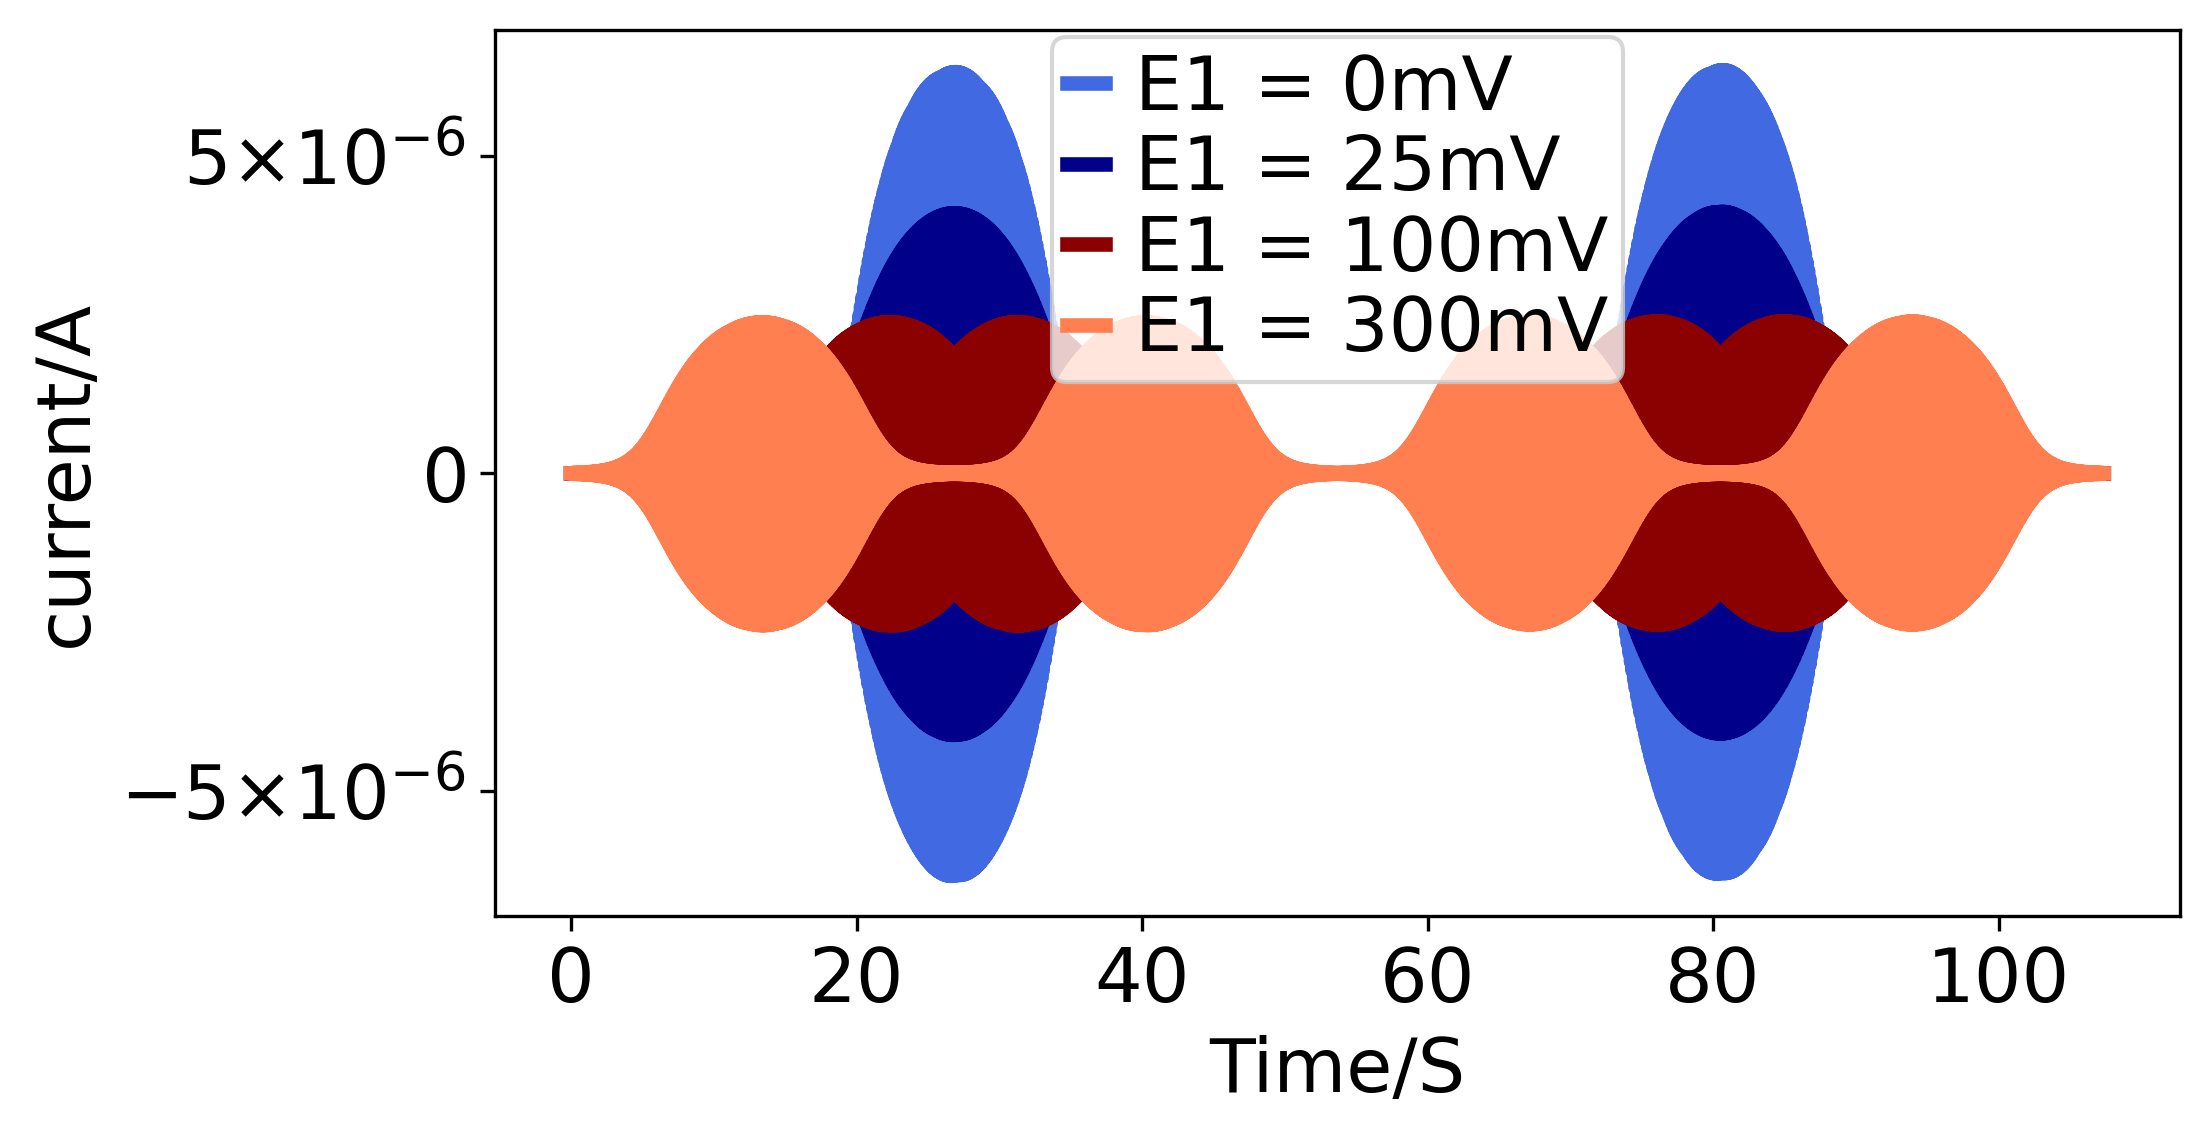

index_window 48.31864296658628
math.ceil(index_window) 49
IFFT_time.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)


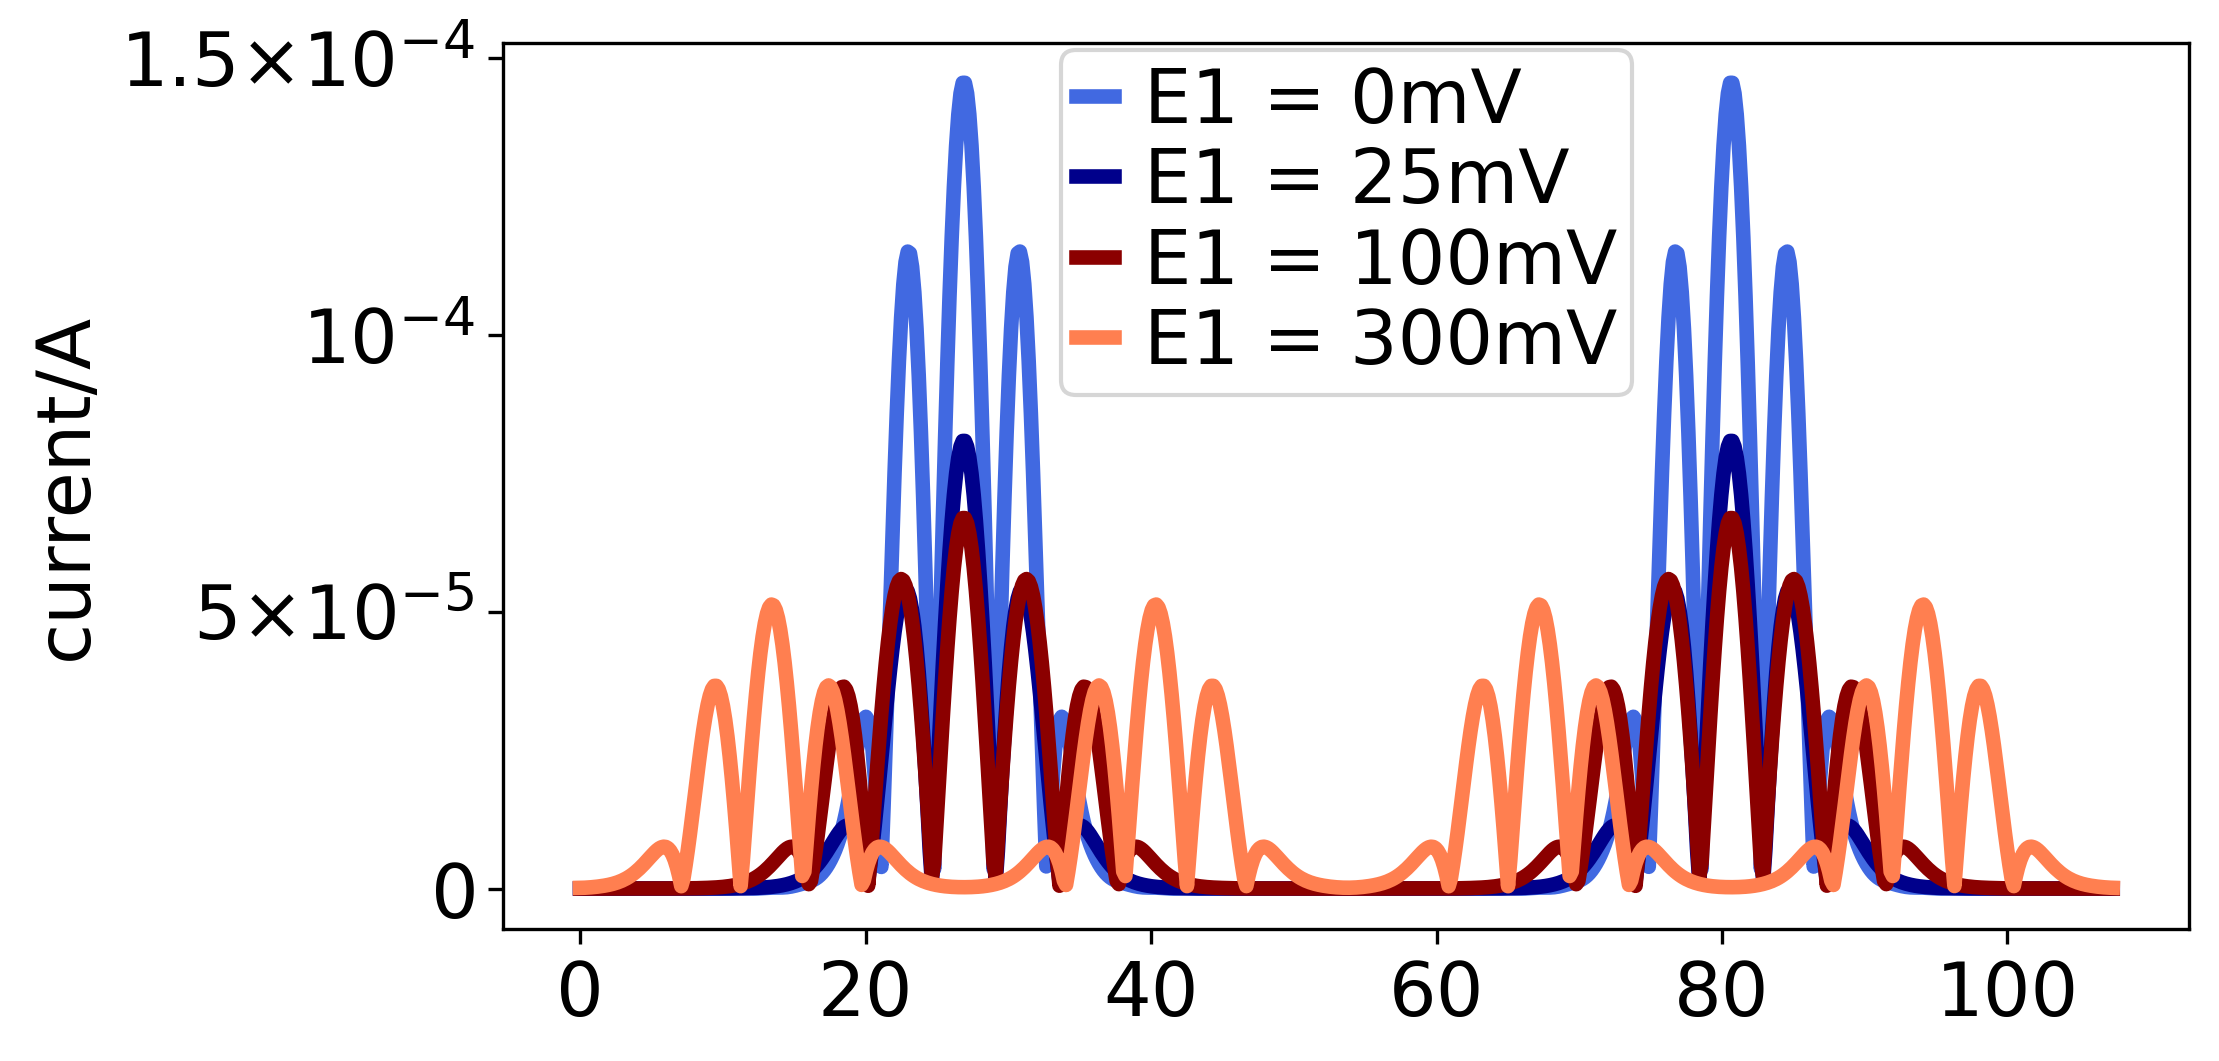

index_window 48.31864296658628
math.ceil(index_window) 49
IFFT_time.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)
sim_harmonic.shape (698,)


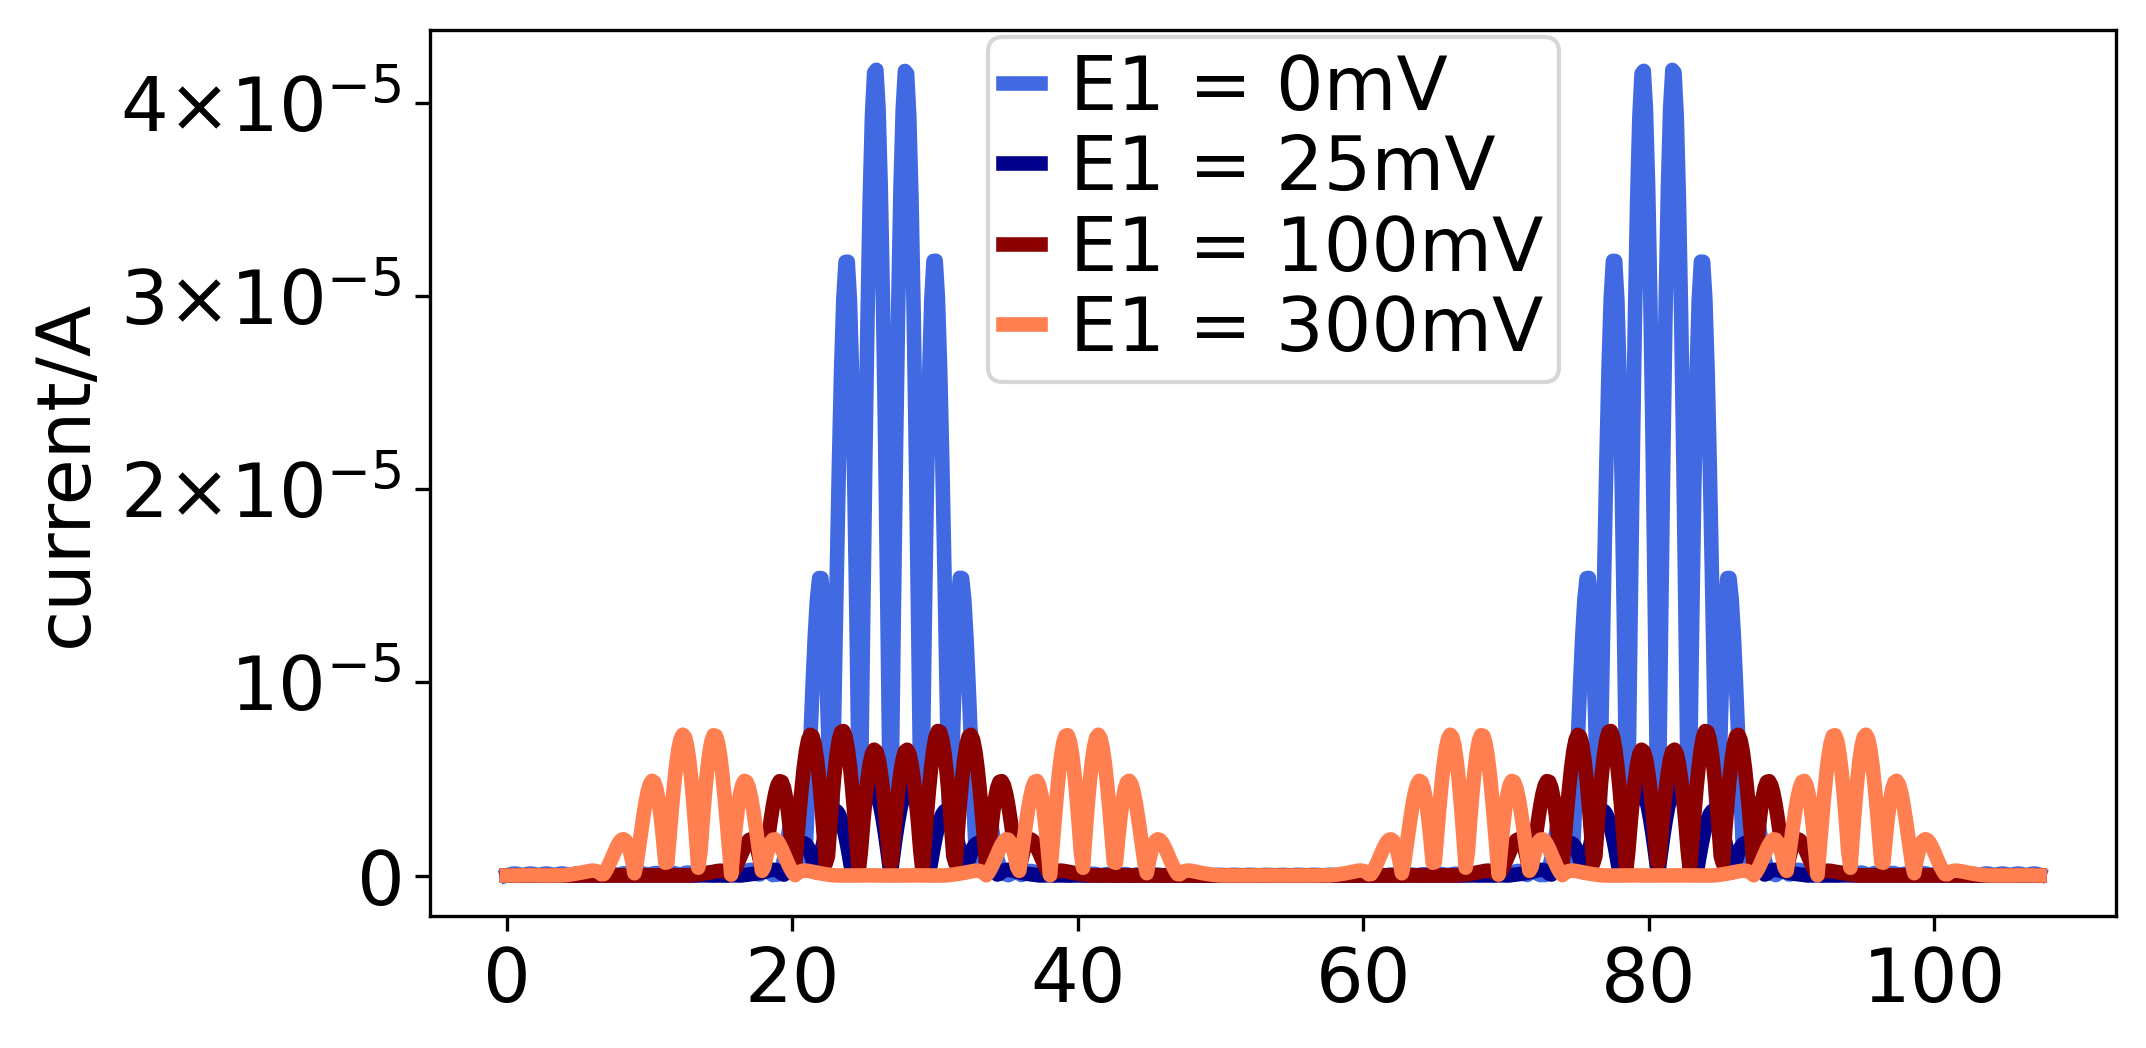

In [10]:
plt.figure()
# plt.title("simulated DC current with E1 > E2 and E1 = -E2")
# plt.ylabel('current/'+r'$\mu$'+'A')
plt.ylabel('current/A')
# plt.xlabel('E/mV')
plt.xlabel('Time/S')

temp = model.get_non_dimensionality_constants()

I0 = temp[2]
 
for index in range(4):

    solution = model.simulate(two_step_faradaic_params[index][:], times)

    colour = ['royalblue', 'darkblue', 'darkred', 'coral']
    label = ['E1 = 0mV', 'E1 = 25mV', 'E1 = 100mV', 'E1 = 300mV']

    plt.plot(times, solution*I0, str(colour[index]), label=str(label[index]))
   

f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(g))
plt.legend(loc='best', markerscale = 0.1, labelspacing = 0.1, handlelength = 0.5, columnspacing = 0.1, borderaxespad = 0.1, handletextpad = 0.4, borderpad = 0.2)
plt.show()
plt.close()

for harmonic in (5, 10):

    index_window = model.index_distance_covering(Hz_interval, times)
    print('index_window', index_window)
    print('math.ceil(index_window)', math.ceil(index_window))
    index_window =  math.ceil(index_window)

    for_calc = int(2*index_window+600)

    startT = 0.0#specify in seconds
    revT =  abs((revPotential - startPotential)/(rateOfPotentialChange))#specify in seconds
    endT = revT*2.0
    first_half_times = np.linspace(startT, revT, for_calc)
    last_half_times = np.linspace(revT, endT, for_calc)
    IFFT_time = np.hstack((first_half_times, last_half_times[1:]))
    IFFT_time = IFFT_time[::2]
    print('IFFT_time.shape', IFFT_time.shape)


    # electode potential variables for epsilon
    potentialRange = np.linspace(startPotential, revPotential, for_calc)
    reversed_potentialRange = np.flip(potentialRange)
    IFFT_fullPotentialRange = np.hstack((potentialRange, reversed_potentialRange[1:]))
    IFFT_fullPotentialRange = IFFT_fullPotentialRange[::2]
    

    plt.figure()
    plt.ylabel('current/A')

    for index in range(4):

        solution = model.simulate(two_step_faradaic_params[index][:], times)

        # non dimesnisionles before FT when graphing!

        solution = solution*I0

        # fourier transforming
        sp = np.fft.fft(solution)

        # discarding half of measurements so that only positive half remains
        sp = sp[:int(numberOfMeasurements)]
        # sp = sp*2

        # working out corresponding requencies
        freq_org = np.fft.fftfreq(times.shape[0], d= model.timeStepSize)
        freq_org=freq_org[:int(numberOfMeasurements)]

        # working out index of the harmonic centre
        x = np.where(freq_org < (freq*harmonic))
        mid_point_index = x[0][-1] +1
        
        # windowing indecies
        mid = int(mid_point_index)
        low = int(mid_point_index - index_window)
        high = int(mid_point_index+ index_window)

        # windowing and adding buffer of zeros
        temp = 300
        mid_upper_sim_plot = sp[mid:high]
        mid_upper_sim_plot = np.hstack((mid_upper_sim_plot, np.zeros(temp)))
        lower_sim_plot = sp[low:mid]
        lower_sim_plot = np.hstack((np.zeros(temp), lower_sim_plot))
        
        # inverse FFT
        array_for_iFFT = np.hstack((mid_upper_sim_plot, lower_sim_plot))
        sim_harmonic = np.fft.ifft(array_for_iFFT)
        sim_harmonic = sim_harmonic

        print('sim_harmonic.shape', sim_harmonic.shape)

        colour = ['royalblue', 'darkblue', 'darkred', 'coral']
        label = ['E1 = 0mV', 'E1 = 25mV', 'E1 = 100mV', 'E1 = 300mV']

        plt.plot(IFFT_time, np.absolute(sim_harmonic), str(colour[index]), label=str(label[index]))
    

    f = mtick.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(g))
    plt.legend(loc='best', markerscale = 0.1, labelspacing = 0.1, handlelength = 0.5, columnspacing = 0.1, borderaxespad = 0.1, handletextpad = 0.4, borderpad = 0.2)
    plt.show()
    plt.close()